**EDA**
  + data load
  + data cleansing
  + data summary

In [1]:
###############
# 1. import
#####

import pandas as pd
from datetime import datetime, timedelta
import re
import time 

# local only
import os
import cx_Oracle as oci
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)


In [2]:

# # DB접속 : 폴 바셋
# con_text = open("C:/Users/MAEIL/conn_MCRM.txt", 'r', encoding='utf8')
# con_text = con_text.read()


# # DB접속 : 셀렉스몰
# con_text = open("C:/Users/MAEIL/conn_SELEX.txt", 'r', encoding='utf8')
# con_text = con_text.read()


In [3]:
###############
# 1.데이터 불러오기
#####
# DB접속 : CRM
con_text = open("C:/Users/MAEIL/conn_CRM.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text, encoding='UTF-8', nencoding='UTF-8')

In [5]:
query = '''
    select  M.USERID
    , I.member_no
    , 2022-to_char(C.birthday, 'YYYY') as age
    , (case when C.sex in ('1', '3') then 'M' when C.sex in ('2', '4') then 'F' end) as gender
    , D.PRODUCT_CODE
    , (case when D.PRODUCT_CODE = 'P00830' then '(곡물)매일두유'
            when D.PRODUCT_CODE = 'P03150' then '(곡물)매일두유'
            when D.PRODUCT_CODE = 'P00144' then '(곡물)매일두유'
            when D.PRODUCT_CODE = 'P03151' then '(곡물)매일두유'
            when D.PRODUCT_CODE = 'P00142' then '(곡물)매일두유'
            when D.PRODUCT_CODE = 'P00145' then '(곡물)매일두유'
            
            when D.PRODUCT_CODE = 'P00138' then '(곡물)아몬드브리즈'
            when D.PRODUCT_CODE = 'P00137' then '(곡물)아몬드브리즈'
            when D.PRODUCT_CODE = 'P00827' then '(곡물)아몬드브리즈'
            when D.PRODUCT_CODE = 'P00139' then '(곡물)아몬드브리즈'
            when D.PRODUCT_CODE = 'P00140' then '(곡물)아몬드브리즈'

            when D.PRODUCT_CODE = 'P03154' then '(곡물)어메이징오트'
            when D.PRODUCT_CODE = 'P03153' then '(곡물)어메이징오트'

            when D.PRODUCT_CODE = 'P03156' then '(커피)바리스타룰스'
            when D.PRODUCT_CODE = 'P03155' then '(커피)바리스타룰스'
            when D.PRODUCT_CODE = 'P00383' then '(커피)바리스타룰스'

            end ) as PRODUCT_NAME_GUBUN
    , D.PRODUCT_PRICE
    , D.PRODUCT_QTY as PRODUCT_COUNT
    , to_char(M.YMDD, 'YYYY-MM-DD') as PAY_DATE
    , to_char(M.YMDD, 'HH24') as PAY_TIME
    from maeil.maeil_ds_delivery M, maeil.MAEIL_DS_DELIVERY_DETAIL D, crm.customer C, crm.member I, mmbship.tm_mmb_info F
    where M.ORDERNO = D.ORDERNO
    and I.userid = M.userid
    and I.member_no = F.unfy_mmb_no
    and F.stff_dv_cd <> '1'
    and D.Product_code in ('P00830', 'P03150', 'P00144', 'P03151', 'P00142', 'P00145', 
                           'P00138', 'P00137', 'P00827', 'P00139', 'P00140',
                           'P03154', 'P03153', 
                           'P03156', 'P03155', 'P00383' )
    and M.USERID = C.id(+) 
    and M.YMDD between sysdate-180 and sysdate
        '''
df_total = pd.read_sql(query, con = conn )

In [6]:

query = '''
    select  M.USERID
    , I.member_no
    , 2022-to_char(C.birthday, 'YYYY') as age
    , (case when C.sex in ('1', '3') then 'M' when C.sex in ('2', '4') then 'F' end) as gender
    , D.PRODUCT_CODE
    , (case when D.PRODUCT_CODE = 'P00830' then '매일두유 검은콩'
            when D.PRODUCT_CODE = 'P03150' then '매일두유 저당'
            when D.PRODUCT_CODE = 'P00144' then '매일두유 식이섬유'
            when D.PRODUCT_CODE = 'P03151' then '매일두유 고단백'
            when D.PRODUCT_CODE = 'P00142' then '매일두유 초콜릿'
            when D.PRODUCT_CODE = 'P00145' then '매일두유 99.9'
            end ) as PRODUCT_NAME_GUBUN
    , D.PRODUCT_PRICE
    , D.PRODUCT_QTY as PRODUCT_COUNT
    , to_char(M.YMDD, 'YYYY-MM-DD') as PAY_DATE
    , to_char(M.YMDD, 'HH24') as PAY_TIME
    from maeil.maeil_ds_delivery M, maeil.MAEIL_DS_DELIVERY_DETAIL D, crm.customer C, crm.member I, mmbship.tm_mmb_info F
    where M.ORDERNO = D.ORDERNO
    and I.userid = M.userid
    and I.member_no = F.unfy_mmb_no
    and F.stff_dv_cd <> '1'
    and D.Product_code in ('P00830', 'P03150', 'P00144', 'P03151', 'P00142', 'P00145')
    and M.USERID = C.id(+) 
    and M.YMDD between sysdate-180 and sysdate
        '''

df_soy = pd.read_sql(query, con = conn )


In [20]:
query = '''
        with buy_product as (
            select replace(수령자전화, '-', '') as cellno , "수령자명", 상품명, 배정일, to_date("배정일",'YYYYMMDD') as reg_dtm
            from mmbship.lkh_emp_master
            where 수령자전화 is not null
            and length(replace(수령자전화, '-', '')) = 11 and to_date(배정일,'YYYYMMDD') between sysdate-90 and sysdate  and 상품명 like '%브리즈%' 
            ),
        user_info as(
            select unfy_mmb_no
            , mmb_nm
            , wrls_tel_no1 || wrls_tel_no2 || wrls_tel_no3 as cellno
            , to_char(sysdate, 'YYYY') - substr(btdy, 1,4 ) as age
            , (case when gndr_dv_cd in ('1', '3') then 'M' when gndr_dv_cd in ('2', '4') then 'F' end) as gender
            from mmbship.tm_mmb_info 
            where mmb_st_cd = '1'
            )
        select U.unfy_mmb_no, U.age, U.gender, B.상품명 as PRODUCT_NAME_GUBUN, B.REG_DTM
        from buy_product B, user_info U
        where B.cellno = U.cellno
        and U.age between 15 and 80
        and B.상품명 not like '%판촉물%'
        and B.상품명 not like '%단계%'
        and B.상품명 not like '%롤케이크%'
        and B.수령자명 = u.mmb_nm
        '''
df_almond = pd.read_sql(query, con = conn )

In [21]:
df_almond.PRODUCT_NAME_GUBUN.unique()

array(['멸균 아몬드브리즈 [ 초콜릿 ] [ 190ml ]', '멸균 아몬드브리즈 [ 식이섬유 ] [ 190ML ]',
       '멸균 아몬드브리즈 [ 프로틴 ] [ 190ml ]', '멸균 아몬드브리즈 [ 오리지널 ] [ 190ml ]',
       '멸균 아몬드브리즈 [ 언스위트 ] [ 190ml ]', '멸균 아몬드브리즈 [ 아몬드&오트 ] [ 190ML ]',
       '멸균 아몬드브리즈 [ 오리지널 ] [ 950ml ]', '[ 선물세트 ] [ 케이스 ] 아몬드브리즈',
       '멸균 아몬드브리즈 [ 언스위트 ] [ 950ml ]',
       '[ 선물세트 ] [ 케이스 ] 아몬드브리즈 [ 카카오선물 ]',
       '멸균 아몬드브리즈 [ 6본 ] [ 아몬드&오트 ] [ 190ML X 6 ]',
       '멸균 아몬드브리즈 [ 언스위트 ] [ 1000 ML ]', '멸균 아몬드브리즈 [ 오리지널 ] [ 1000 ML ]'],
      dtype=object)

In [26]:
df_almond = df_almond.replace('멸균 아몬드브리즈 [ 프로틴 ] [ 190ml ]',     '아몬드브리즈 [ 프로틴 ]')
df_almond = df_almond.replace('멸균 아몬드브리즈 [ 오리지널 ] [ 190ml ]',   '아몬드브리즈 [ 오리지널 ]')
df_almond = df_almond.replace('멸균 아몬드브리즈 [ 언스위트 ] [ 190ml ]',   '아몬드브리즈 [ 언스위트 ]')
df_almond = df_almond.replace('멸균 아몬드브리즈 [ 아몬드&오트 ] [ 190ML ]','아몬드브리즈 [ 아몬드&오트 ]')
df_almond = df_almond.replace('멸균 아몬드브리즈 [ 식이섬유 ] [ 190ML ]',   '아몬드브리즈 [ 식이섬유 ]')

df_almond = df_almond.replace('멸균 아몬드브리즈 [ 6본 ] [ 언스위트 ] [ 190ml ]',   '아몬드브리즈 [ 오리지널 ]')
df_almond = df_almond.replace('멸균 아몬드브리즈 [ 6본 ] [ 오리지널 ] [ 190ml ]',   '아몬드브리즈 [ 언스위트 ]')
df_almond = df_almond.replace('멸균 아몬드브리즈 [ 6본 ] [ 프로틴 ] [ 190ml ]',   '아몬드브리즈 [ 언스위트 ]')
df_almond = df_almond.replace('멸균 아몬드브리즈 [ 초콜릿 ] [ 190ml ]',   '아몬드브리즈 [ 초콜릿 ]')

df_almond = df_almond.replace('멸균 아몬드브리즈 [ 6본 ] [ 아몬드&오트 ] [ 190ML X 6 ]',   '아몬드브리즈 [ 아몬드&오트 ]')

In [35]:
df_almond = df_almond[df_almond['PRODUCT_NAME_GUBUN'] != '[ 선물세트 ] [ 케이스 ] 아몬드브리즈 [ 카카오선물 ]'].reset_index(drop=True)
df_almond = df_almond[df_almond['PRODUCT_NAME_GUBUN'] != '멸균 아몬드브리즈 [ 바나나 ] [ 190ml ]'].reset_index(drop=True)

df_almond = df_almond[df_almond['PRODUCT_NAME_GUBUN'] != '멸균 아몬드브리즈 [ 오리지널 ] [ 950ml ]'].reset_index(drop=True)
df_almond = df_almond[df_almond['PRODUCT_NAME_GUBUN'] != '멸균 아몬드브리즈 [ 언스위트 ] [ 950ml ]'].reset_index(drop=True)
df_almond = df_almond[df_almond['PRODUCT_NAME_GUBUN'] != '멸균 아몬드브리즈 [ 오리지널 ] [ 1000 ML ]'].reset_index(drop=True)
df_almond = df_almond[df_almond['PRODUCT_NAME_GUBUN'] != '멸균 아몬드브리즈 [ 언스위트 ] [ 1000 ML ]'].reset_index(drop=True)

In [36]:
df_almond.PRODUCT_NAME_GUBUN.unique()

array(['아몬드브리즈 [ 초콜릿 ]', '아몬드브리즈 [ 식이섬유 ]', '아몬드브리즈 [ 프로틴 ]',
       '아몬드브리즈 [ 오리지널 ]', '아몬드브리즈 [ 언스위트 ]', '아몬드브리즈 [ 아몬드&오트 ]',
       '[ 선물세트 ] [ 케이스 ] 아몬드브리즈'], dtype=object)

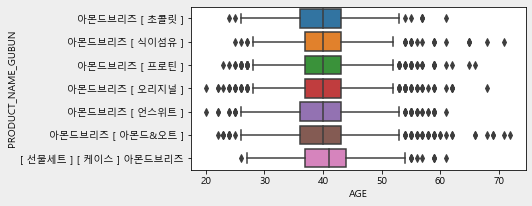

In [37]:
mpl.rc('figure', figsize=(6, 3), facecolor='#eeeeee' )
sns.boxplot(x="AGE", y="PRODUCT_NAME_GUBUN", data=df_almond)
# plt.title("요일 별 전체 팁의 Box Plot")
plt.show()

In [38]:
# pd.DataFrame(df_maeili.groupby(['PRODUCT_NAME_GUBUN', 'GENDER' ])['AGE'].count())
pd.pivot_table(df_almond, values='AGE', index=['PRODUCT_NAME_GUBUN',], columns = 'GENDER', aggfunc='count')

GENDER,F,M
PRODUCT_NAME_GUBUN,,
[ 선물세트 ] [ 케이스 ] 아몬드브리즈,208,7
아몬드브리즈 [ 식이섬유 ],428,24
아몬드브리즈 [ 아몬드&오트 ],2951,164
아몬드브리즈 [ 언스위트 ],915,77
아몬드브리즈 [ 오리지널 ],2189,152
아몬드브리즈 [ 초콜릿 ],708,33
아몬드브리즈 [ 프로틴 ],1585,151


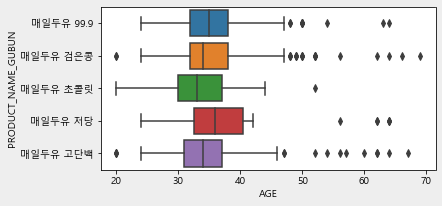

In [41]:
mpl.rc('figure', figsize=(6, 3), facecolor='#eeeeee' )
sns.boxplot(x="AGE", y="PRODUCT_NAME_GUBUN", data=df_soy)
# plt.title("요일 별 전체 팁의 Box Plot")
plt.show()

In [27]:
# pd.DataFrame(df_maeili.groupby(['PRODUCT_NAME_GUBUN', 'GENDER' ])['AGE'].count())
pd.pivot_table(df_almond, values='AGE', index=['PRODUCT_NAME_GUBUN',], columns = 'GENDER', aggfunc='count')

GENDER,F,M
PRODUCT_NAME_GUBUN,,
멸균 아몬드브리즈 [ 초콜릿 ] [ 190ml ],484,23
아몬드브리즈 [ 식이섬유 ] [ 190ML ],233,24
아몬드브리즈 [ 아몬드&오트 ] [ 190ml ],715,112
아몬드브리즈 [ 언스위트 ] [ 190ml ],596,48
아몬드브리즈 [ 오리지널 ] [ 190ml ],2003,141
아몬드브리즈 [ 프로틴 ] [ 190ml ],1937,160


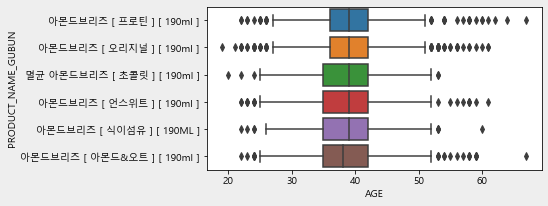

In [28]:
mpl.rc('figure', figsize=(6, 3), facecolor='#eeeeee' )
sns.boxplot(x="AGE", y="PRODUCT_NAME_GUBUN", data=df_almond)
# plt.title("요일 별 전체 팁의 Box Plot")
plt.show()

In [13]:
pd.pivot_table(df_soy, values='AGE', index=['PRODUCT_NAME_GUBUN',], columns = 'GENDER', aggfunc='count').T

PRODUCT_NAME_GUBUN,매일두유 99.9,매일두유 검은콩,매일두유 고단백,매일두유 식이섬유,매일두유 저당,매일두유 초콜릿
GENDER,,,,,,
F,1320,1576,181,690,114,496
M,183,185,24,58,12,57


In [14]:
sns.boxplot(x="AGE", y="PRODUCT_NAME_GUBUN", hue="GENDER", data=df_grain)
# plt.title("요일 별, 성별 전체 팁의 Box Plot")
plt.show()

NameError: name 'df_grain' is not defined

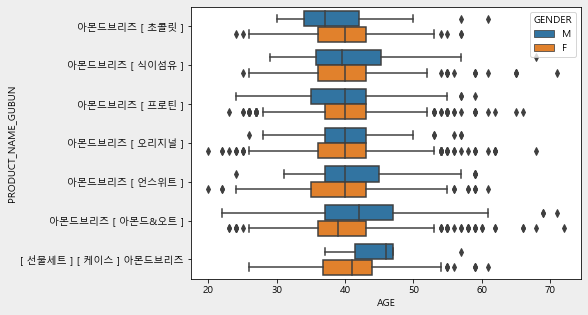

In [39]:
mpl.rc('figure', figsize=(7, 5), facecolor='#eeeeee' )
hue_order=['M', 'F']
sns.boxplot(x="AGE", y="PRODUCT_NAME_GUBUN", hue="GENDER", data=df_almond, hue_order= hue_order)
# plt.title("요일 별, 성별 전체 팁의 Box Plot")
plt.show()

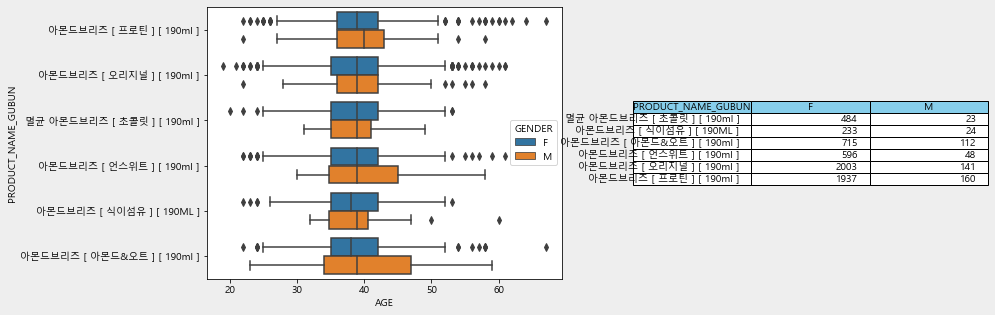

In [30]:
mpl.rc('figure', figsize=(14, 5), facecolor='#eeeeee' )

ax1 = plt.subplot2grid((1, 2), (0, 0))
sns.boxplot(x="AGE", y="PRODUCT_NAME_GUBUN", hue="GENDER", data=df_almond)

# data=[[1,2,3],
#       [5,6,7],
#       [8,9,10]]
# column_labels=["Column 1", "Column 2", "Column 3"]


ax2 = plt.subplot2grid((1, 2), (0, 1))
df=pd.pivot_table(df_almond, values='AGE', index=['PRODUCT_NAME_GUBUN',], columns = 'GENDER', aggfunc='count').reset_index()
# ax2.axis('tight')
ax2.axis('off')
ax2.table(cellText=df.values, colLabels=df.columns, colColours =["skyblue"] * 3, loc="center").auto_set_font_size(False)

# plt.title("요일 별, 성별 전체 팁의 Box Plot")
plt.show()

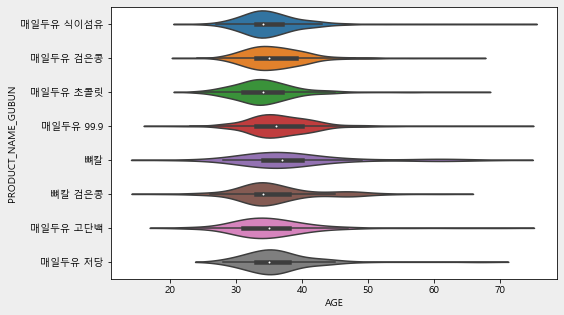

In [26]:
mpl.rc('figure', figsize=(8, 5), facecolor='#eeeeee' )
sns.violinplot(x="AGE", y="PRODUCT_NAME_GUBUN", data=df_maeili)
# plt.title("요일 별 전체 팁의 Box Plot")
plt.show()

In [96]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta

# 내용공유(e-mail, 회사) 
# import send_email as se
from jinja2 import Template

import warnings
warnings.filterwarnings("ignore")

#폴더 내용 불러오기
from glob import glob
import os 
from google.cloud import bigquery
from nltk import FreqDist

import gspread

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [97]:
def data_get_90day(category_group, category_keyword):
    ###############
    # 2.자료 추출 : MySQL
    #####
    # BigQuery 접속 정보 
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./************************.json"
    client = bigquery.Client()
    # 쿼리실행
    sql = """SELECT USER
             , FORMAT_DATETIME('%Y-%m-%d', CAST(A.DATE AS DATETIME)) as REG_DTM
             , FORMAT_DATETIME('%Y-%m', CAST(A.DATE AS DATETIME)) as REG_DT
             , FORMAT_DATETIME('%YY-%VW', CAST(A.DATE AS DATETIME)) as REG_WEEK
             , CHANNEL
             , PRODUCT
             , REVIEW
             , SCORE
             FROM `thermal-rain-234004.review.review_all` A
             where PRODUCT like '%"""+category_group+"""%'
             and PRODUCT like '%"""+category_keyword+"""%'
             and CAST(A.DATE AS DATETIME) between DATE_SUB(current_date(), INTERVAL 90 DAY) and DATE_SUB(current_date(), INTERVAL -1 DAY)
             order by CAST(A.DATE AS DATETIME) desc"""
    df1 = client.query(sql).to_dataframe()
    df1 = df1.replace('kakaomakers', '카카오 선물하기')

    ###############
    # 2.자료 추출 : MySQL
    #####
    # 접속 정보 
    conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')
    cursor = conn.cursor(pymysql.cursors.DictCursor)

    # 쿼리실행: 전체리뷰
    sql= '''select A.WRITER as USER
            , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as REG_DTM 
            , left((STR_TO_DATE(A.WRITE_DT, '%Y%m%d')),7)  as REG_DT 
            , DATE_FORMAT(STR_TO_DATE(A.WRITE_DT, '%Y%m%d'),'%YY-%uW' )  as REG_WEEK 
            , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as CHANNEL 
            , group_concat(distinct B.CODE_NM order by CODE_NM asc) as PRODUCT
            , A.GRADE as SCORE
            , trim(A.CONTENTS) as REVIEW
            FROM MAEIL_REVIEW A, JT_CODE B
            where A.GRADE in (1,2,3,4,5)
            and CAST(STR_TO_DATE(A.WRITE_DT, '%Y%m%d') AS DATETIME) between DATE_SUB(current_date(), INTERVAL 90 DAY) and DATE_SUB(current_date(), INTERVAL -1 DAY)
            and A.PRODUCT_CODE = B.CODE 
            AND B.CODE_NM like '%'''+category_group +'''%'
            AND B.CODE_NM like '%'''+category_keyword +'''%'
            and B.CODE not like'G_%'
            group by A.WRITER, A.WRITE_DT, A.COMPANY_CODE, GRADE, CONTENTS
            order by A.WRITE_DT desc
            '''
    cursor.execute(sql)
    df2 = cursor.fetchall()
    df2 = pd.DataFrame(df2)

    df2 = df2.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')

    df = pd.concat([df1, df2], ignore_index=True)
    df['REG_DTM'] = pd.to_datetime(df['REG_DTM'],format = '%Y-%m-%d')
    # df['REG_DTM'] = df['REG_DTM']
    df.PRODUCT = df.PRODUCT.str.lower() 
    df['SCORE'] = df['SCORE'].astype(float)
    df['REVIEW'] = df['REVIEW'].str.replace('\n', ' ')
    df['lenght'] = df['REVIEW'].str.len()

    df = df[df.lenght != 0]
    df = df.reset_index(drop=True)
    return df

In [98]:
category_group, category_keyword  = '오트', '오리지널'
df_1 = data_get_90day(category_group, category_keyword)

In [99]:
category_group, category_keyword  = '두유', '저당'
df_2 = data_get_90day(category_group, category_keyword)

In [100]:
category_group, category_keyword  = '두유', '99'
df_3 = data_get_90day(category_group, category_keyword)

In [101]:
category_group, category_keyword  = '두유', '검은콩'
df_4 = data_get_90day(category_group, category_keyword)

In [102]:
category_group, category_keyword  = '두유', '초콜릿'
df_5 = data_get_90day(category_group, category_keyword)

In [103]:
category_group, category_keyword  = '두유', '[ 식이섬유 ]'
df_6 = data_get_90day(category_group, category_keyword)

In [117]:
category_group, category_keyword  = '오트', '언스위트'
df_7 = data_get_90day(category_group, category_keyword)

In [116]:
category_group, category_keyword  = '오트', '바리스타'
df_8 = data_get_90day(category_group, category_keyword)

In [118]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], ignore_index=True)

In [143]:
df = df.replace('매일두유: 선택3. 매일두유 초콜릿 190ml 24팩', '멸균 매일두유 [ 99.89 ] [ 190ml ]')
df = df.replace('매일두유: 선택4. 매일두유 검은콩 190ml 24팩', '멸균 매일두유 [ 검은콩 ] [ 190ml ]')
df = df.replace('매일유업 매일두유 식이섬유 저당 190ml x 24팩', '멸균 매일두유 [ 식이섬유 저당 ] [ 190ml ]')
df = df.replace('어메이징 오트 오리지널 190ml 24팩', '어메이징 오트 [ 오리지널 ] [ 190ml ]')
df = df.replace('어메이징 오트 오리지널 190ml 48팩', '어메이징 오트 [ 오리지널 ] [ 190ml ]')
df = df.replace('선택: 어메이징 오트 오리지널', '어메이징 오트 [ 오리지널 ] [ 190ml ]')
df = df.replace('뼈로가는 칼슘두유: 검은콩 190ml 24팩', '멸균 매일두유 [ 고칼슘 검은콩 ] [ 190ml ]')
df = df.replace('멸균 매일두유 [ 99.89 ] [ 950ml ] ,멸균 매일두유 [ 99.9 ] [ new ] [ 950ml ] ', '멸균 매일두유 [ 99.89 ] [ 950ml ]')
df = df.replace('멸균 매일두유 [ 99.89 ] [ 950ml ] ', '멸균 매일두유 [ 99.89 ] [ 950ml ]')

df = df.replace('[매일유업] 어메이징오트 바리스타 950ml x 3팩', '어메이징 오트 [ 바리스타 ] [ 950ml ]')
df = df.replace('매일유업 어메이징 오트 바리스타 950ml 3팩', '어메이징 오트 [ 바리스타 ] [ 950ml ]')

df = df.replace('어메이징 오트 언스위트 190ml 48팩', '어메이징 오트 [ 언스위트 ] [ 190ml ]')

In [144]:

df.loc[df['PRODUCT'] =='어메이징 오트 [ 바리스타 ] [ 950ml ]', 'PRODUCT_GUBUN'] = '어메이징오트 바리스타'
df.loc[df['PRODUCT'] =='어메이징 오트 [ 오리지널 ] [ 190ml ]', 'PRODUCT_GUBUN'] = '어메이징오트 오리지널'
df.loc[df['PRODUCT'] =='어메이징 오트 [ 언스위트 ] [ 190ml ]', 'PRODUCT_GUBUN'] = '어메이징오트 언스위트'
df.loc[df['PRODUCT'] =='멸균 매일두유 [ 99.89 ] [ 190ml ]',    'PRODUCT_GUBUN'] = '두유 오리지널'
df.loc[df['PRODUCT'] =='멸균 매일두유 [ 99.89 ] [ 950ml ]',    'PRODUCT_GUBUN'] = '두유 오리지널'
df.loc[df['PRODUCT'] =='멸균 매일두유 [ 검은콩 ] [ 190ml ]',   'PRODUCT_GUBUN'] = '두유 검은콩'
df.loc[df['PRODUCT'] =='멸균 매일두유 [ 고칼슘 검은콩 ] [ 190ml ]','PRODUCT_GUBUN'] = '두유 고칼슘 검은콩'
df.loc[df['PRODUCT'] =='멸균 매일두유 [ 식이섬유 ] [ 190ml ]', 'PRODUCT_GUBUN'] = '두유 식이섬유'
df.loc[df['PRODUCT'] =='멸균 매일두유 [ 식이섬유 저당 ] [ 190ml ]','PRODUCT_GUBUN'] = '두유 식이섬유저당'
df.loc[df['PRODUCT'] =='멸균 매일두유 [ 초콜릿 ] [ 190ml ]',    'PRODUCT_GUBUN'] = '두유 초콜릿'



In [148]:
df = df.dropna()

In [153]:
pd.DataFrame(df.groupby('PRODUCT')['PRODUCT_GUBUN'].count().sort_values(ascending = False)).reset_index()

,PRODUCT,PRODUCT_GUBUN
0,어메이징 오트 [ 오리지널 ] [ 190ml ],9427
1,멸균 매일두유 [ 99.89 ] [ 190ml ],5950
2,멸균 매일두유 [ 검은콩 ] [ 190ml ],3484
3,어메이징 오트 [ 바리스타 ] [ 950ml ],3387
4,어메이징 오트 [ 언스위트 ] [ 190ml ],2625
5,멸균 매일두유 [ 식이섬유 저당 ] [ 190ml ],2523
6,멸균 매일두유 [ 식이섬유 ] [ 190ml ],1172
7,멸균 매일두유 [ 초콜릿 ] [ 190ml ],582
8,멸균 매일두유 [ 99.89 ] [ 950ml ],335
9,멸균 매일두유 [ 고칼슘 검은콩 ] [ 190ml ],197


In [157]:
df[df['PRODUCT']=='멸균 매일두유 [ 검은콩 ] [ 190ml ]'].head(10)

,USER,REG_DTM,REG_DT,REG_WEEK,CHANNEL,PRODUCT,REVIEW,SCORE,lenght,PRODUCT_GUBUN
18612,625e7658672b281c884e69ea,2022-04-19,2022-04,2022Y-16W,카카오 선물하기,멸균 매일두유 [ 검은콩 ] [ 190ml ],맛있어요 담백하고 고소하고 달지않아 좋네요~단백질 함유량도 꽤 되니 더 ㅈᆢㅎ아요,5.0,45,두유 검은콩
18613,624fc56122618f58eada2ba2,2022-04-08,2022-04,2022Y-14W,카카오 선물하기,멸균 매일두유 [ 검은콩 ] [ 190ml ],빠른배송감사합니다~~~~~,5.0,14,두유 검은콩
18614,624c1eba09769135bdd31cd3,2022-04-05,2022-04,2022Y-14W,카카오 선물하기,멸균 매일두유 [ 검은콩 ] [ 190ml ],건강을 생각해주는 따뜻한 마음까지 기분 좋네요,5.0,25,두유 검은콩
18620,wogu*******,2022-06-08,2022-06,2022Y-23W,3 네이버,멸균 매일두유 [ 검은콩 ] [ 190ml ],항상배송빠르고 믿고 주문합니다,5.0,16,두유 검은콩
18621,wooj*****,2022-06-08,2022-06,2022Y-23W,3 네이버,멸균 매일두유 [ 검은콩 ] [ 190ml ],만족해요 달지않고 맛있어요 !,5.0,16,두유 검은콩
18622,xxmi****,2022-06-08,2022-06,2022Y-23W,3 네이버,멸균 매일두유 [ 검은콩 ] [ 190ml ],좋아요 만족합니다 굿굿,5.0,12,두유 검은콩
18623,yam7***,2022-06-08,2022-06,2022Y-23W,3 네이버,멸균 매일두유 [ 검은콩 ] [ 190ml ],아몬드부터 99.9까지 종류별로 다 마시고 있어요. 텁텁하거나 비리지 않아요. 건강...,5.0,66,두유 검은콩
18624,yuna****,2022-06-08,2022-06,2022Y-23W,3 네이버,멸균 매일두유 [ 검은콩 ] [ 190ml ],배송빨랐구용 포장상태 훌륭합니다. 매일흰우유만 시켜먹다가 검은콩두유 첨시켜보는데 ...,5.0,64,두유 검은콩
18625,soob*****,2022-06-08,2022-06,2022Y-23W,3 네이버,멸균 매일두유 [ 검은콩 ] [ 190ml ],매일! 매일! 매일! 매일! 매일!,5.0,19,두유 검은콩
18626,tcr0****,2022-06-08,2022-06,2022Y-23W,3 네이버,멸균 매일두유 [ 검은콩 ] [ 190ml ],좀덜달지만 맛있어요!,5.0,11,두유 검은콩


In [ ]:
import text_to_token as tt

df5 = tt.text_to_token(df)

In [ ]:

def get_keyword(keyword, gubun1, gubun2 ):
    df.loc[(df['token'].str.contains(str(keyword))), 'KEYWORD'] = keyword
    df.loc[(df['KEYWORD'] ==keyword), 'GROUP2'] = gubun2
    df.loc[(df['KEYWORD'] ==keyword), 'GROUP1'] = gubun1



df['GROUP2'] = '(미분류)'
df['GROUP1'] = '(미분류)'


keyword8 = ['맛', '밍밍', '고소', '비리다', '냄새', '맛없다', '달다', 
            '단백','담백', '칼로리', '달달', '담백', '꿀', '꿀맛',
            '취향', '고소하', '향료', '식물성', '무설탕', '고소한', '은은한', 
            '짜다', '당뇨',
           ]
for word in keyword8:
    get_keyword(word, '제품', '맛(미각)')

    
keyword8 = ['맛', '밍밍', '고소', '비리다', '냄새', '맛없다', '달다', 
            '단백','담백', '칼로리', '달달', '담백', '꿀', '꿀맛',
            '취향', '고소하', '향료', '식물성', '무설탕', '고소한', '은은한', 
            '짜다', '당뇨',
           ]
for word in keyword8:
    get_keyword(word, '제품', '맛(성분)')


keyword8 = ['향료', '비리다', '냄새',
            '텁텁', '진하다', '풍미', '거품', '부드럽다', '걸쭉',]
for word in keyword8:
    get_keyword(word, '제품', '맛(촉각/후각)')



In [23]:
# # Excel 다운로드
# date2 = datetime.today().strftime('%Y%m%d')
# excel_name = date2 +'_PBS_targetting_rawdata.xlsx'
# df3.to_excel(excel_name, sheet_name= 'Sheet1' )